In [290]:
!pip install sqlalchemy-mate==2.0.0
!pip install kagglehub
!pip install uszipcode
!pip install joypy

In [291]:
import os
import kagglehub
import pandas as pd
import numpy as np
from datetime import date
from uszipcode import SearchEngine

import matplotlib.pyplot as plt
import seaborn as sns
import math

import joypy

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score

from xgboost import XGBClassifier


In [292]:
path = kagglehub.dataset_download("mirbektoktogaraev/should-this-loan-be-approved-or-denied")


dataset_files = os.listdir(path)
print("Files in the dataset subfolder:", dataset_files)

csv_file = [file for file in dataset_files if file.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)

credit = pd.read_csv(csv_path)
print("Dataset preview:")
credit.head()

Files in the dataset subfolder: ['SBAnational.csv', 'Should This Loan be Approved or Denied A Large Dataset with Class Assignment Guidelines.pdf']


<ipython-input-292-5773fd58a10f>:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  credit = pd.read_csv(csv_path)


Dataset preview:


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


# Preprocessing and data cleaning

In [293]:
#Deleting duplicates if any
print( credit.shape)
credit = credit.drop_duplicates(keep = 'first')
credit.shape

(899164, 27)


(899164, 27)

There were no duplicates.

-----------------

In [294]:
credit['ApprovalDate'] = credit['ApprovalDate'].astype(str)
credit['ApprovalDate'] = pd.to_datetime(credit['ApprovalDate'])
credit['GrAppv'] = credit['GrAppv'].replace({'\$': '', ',': ''}, regex=True).astype(float)

<ipython-input-294-47c3ad6db10c>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  credit['ApprovalDate'] = pd.to_datetime(credit['ApprovalDate'])


In [295]:
credit.describe()

,LoanNr_ChkDgt,Zip,NAICS,ApprovalDate,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,GrAppv
count,8.991640e+05,899164.000000,899164.000000,899164,899164.000000,899164.000000,899028.000000,899164.000000,899164.000000,899164.000000,899164.000000,8.991640e+05
mean,4.772612e+09,53804.391241,398660.950146,2001-06-04 11:57:49.414700416,110.773078,11.411353,1.280404,8.430376,10.797257,2753.725933,0.757748,1.926870e+05
min,1.000014e+09,0.000000,0.000000,1974-01-09 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+02
25%,2.589758e+09,27587.000000,235210.000000,1996-11-22 00:00:00,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.500000e+04
50%,4.361439e+09,55410.000000,445310.000000,2002-09-27 00:00:00,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,9.000000e+04
75%,6.904627e+09,83704.000000,561730.000000,2006-01-20 00:00:00,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.250000e+05
max,9.996003e+09,99999.000000,928120.000000,2073-12-20 00:00:00,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,5.472000e+06
std,2.538175e+09,31184.159152,263318.312759,NaN,78.857305,74.108196,0.451750,236.688165,237.120600,12758.019136,0.646436,2.832634e+05


In [296]:
credit.isnull().sum()

,0
LoanNr_ChkDgt,0
Name,14
City,30
State,14
Zip,0
Bank,1559
BankState,1566
NAICS,0
ApprovalDate,0
ApprovalFY,0


<ipython-input-297-a3ec92019029>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='rocket')


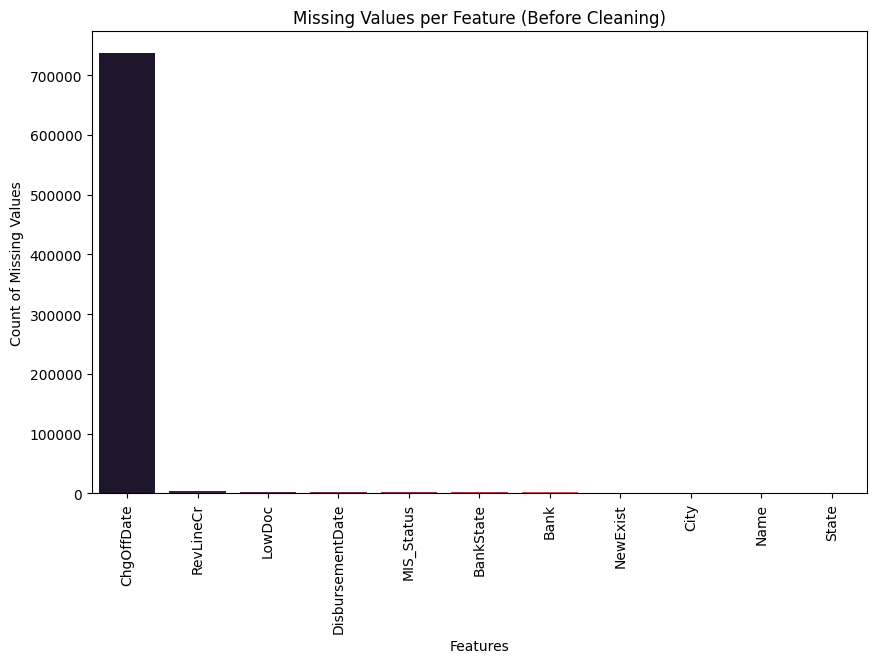

In [297]:
missing_counts = credit.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='rocket')
plt.xticks(rotation=90)
plt.title("Missing Values per Feature (Before Cleaning)")
plt.ylabel("Count of Missing Values")
plt.xlabel("Features")
plt.show()


We have a thousands of NAs in many columns. It seems like we will have to go through them and decide how we treat them.

-------------

The most important column is MIS_Status. This is the columns that we are trying to predict, the one that shows if the loan has been paid in full (PIF) or charged off (CHGOFF). As we can see in the last cell, we have 1997 NAs on this column:

In [298]:
credit.MIS_Status.unique()

array(['P I F', 'CHGOFF', nan], dtype=object)

Now we will go attribute to attribute dealing with NAs.

The columns with the most of these is ChgOffDate. From reading about the dataset I understand that this column has a date assigned if the loan was charged off, and it has an NA value if it was paid in full.

Because of its nature, it seems like this is not a necessary column in order to predict the loan outcome. Since it doesn't give us any information, we will simply drop it from the dataset.

In [299]:
credit = credit.drop(columns = 'ChgOffDate')

The next higher number of NAs is found in the attribute RevLineCr.

In [300]:
credit.RevLineCr.unique()

array(['N', '0', 'Y', 'T', nan, '`', ',', '1', 'C', '3', '2', 'R', '7',
       'A', '5', '.', '4', '-', 'Q'], dtype=object)

We will need to make further research about this column, since it seems to have many different possible values and I still don't completely understand their meanings.

In [301]:
credit.RevLineCr.value_counts(dropna=False)

,count
RevLineCr,
N,420288
0,257602
Y,201397
T,15284
NaN,4528
1,23
R,14
`,11
2,6


From the description of the dataset in both the [kaggle website](https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied/data) and the [original dataset documentation](https://www.tandfonline.com/doi/full/10.1080/10691898.2018.1434342?scroll=top&needAccess=true#abstract) it seems like the only two possible values for this attribute should be Y for Yes and N for No. This leads me to believe that the rest of values are input mistakes, and should be treated similarly to nans.

This makes treatment of this column particularly difficult since we are looking at a number of nans that exceeds the size of one of the possible values.

In [302]:
invalid_count = credit[~credit['RevLineCr'].isin(['Y', 'N', np.nan])].shape[0]
invalid_count, credit['RevLineCr'].value_counts().get('Y')


(272951, 201397)

I have certain assumptions about what some of the mistaken inputs could mean. For example, it is reasonable to think that the very prevalent 0 input is referencing that the applicant has no line of credit (0 and 1 are usually used as negative and affirmative values in bool attributes). With that said, I don't think simply using that assumption to replace the values would be sufficient, specially considering that the proportion of 0s and 1s that we have is completely different from that of Ns and Ys.

The problem that we have is that now we are looking at around 25% of our dataset having an incorrect value in this column. I think that the decision here should be to decide whether we drop the entire column or we drop all the rows that have a NA value in this attribute.

Although there are many, I think the best possible treatment for the rest nans would be to simply drop them from our working data. We still have plenty of values to work with, and this probably will remove some of our other faulty inputs in other columns. The column seems to be important to out predictions, since having a line of credit seems like an important factor in predicting whether you will be able to pay the loan or not.

I make the decision to drop the rows, but I might come look at this column in the future.

In [303]:
credit['RevLineCr'] = credit['RevLineCr'].where(credit['RevLineCr'].isin(['N', 'Y']), np.nan)
credit.RevLineCr.value_counts(dropna=False)

,count
RevLineCr,
N,420288
NaN,277479
Y,201397


In [304]:
credit = credit.dropna(subset=['RevLineCr'])
credit.RevLineCr.value_counts(dropna=False)

,count
RevLineCr,
N,420288
Y,201397


Let's see the effect that this change has had in our overall NA count.

In [305]:
credit.shape[0]

621685

In [306]:
credit.isnull().sum()

,0
LoanNr_ChkDgt,0
Name,9
City,30
State,14
Zip,0
Bank,1532
BankState,1538
NAICS,0
ApprovalDate,0
ApprovalFY,0


Sadly, there have not been many changes to our count of nans in other columns.

----

The next columns that I will take a look at are 'LowDoc' and 'DisbursementDate'.

DisbursementDate, as the name states, is the date in which the loan was disbursed. This only applies after default has been declared, so it has no influence into our prediction.

We will simply drop the column.

In [307]:
credit = credit.drop(columns = 'DisbursementDate')
credit.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,...,1,0,N,Y,"$60,000.00",$0.00,P I F,$0.00,60000.0,"$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,...,1,0,N,Y,"$40,000.00",$0.00,P I F,$0.00,40000.0,"$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,...,1,0,N,N,"$287,000.00",$0.00,P I F,$0.00,287000.0,"$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,...,1,0,N,Y,"$35,000.00",$0.00,P I F,$0.00,35000.0,"$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,...,1,0,N,N,"$229,000.00",$0.00,P I F,$0.00,229000.0,"$229,000.00"


From my understanding, [LowDoc](https://www.entrepreneur.com/encyclopedia/lowdoc) seems to refer to a special type of loan program which was given for smaller quantities. This program required less documents and so the process and approval was easier.

It seems to be an important predictor and so I will do what I can to mantain its integrity.

In [308]:
credit.LowDoc.unique()

array(['Y', 'N', 'C', '1', nan, 'S', 'R', 'A', '0'], dtype=object)

In [309]:
credit.LowDoc.value_counts(dropna=False)

,count
LowDoc,
N,559138
Y,57438
NaN,2531
0,1151
C,698
S,566
A,104
R,58
1,1


Similarly to what we have seen before, this columns is supposed to only have Y and N values. Thankfully, in this case the incorrect values seem to be much lower to the correct ones.

In [310]:
credit['LowDoc'].isin(['Y', 'N']).sum(), (~credit['LowDoc'].isin(['Y', 'N'])).sum()

(616576, 5109)

I would like to be able to fill as many of these nans with values that make sense. So I will try to see if I can find any patterns that allow me to confidently guess the values.

In [311]:
# Select only the nan values
nans = credit[(credit['LowDoc'] != "Y") & (credit['LowDoc'] != "N")]

In [312]:
# Select the lowdoc approved loans
lowdoc = credit[credit['LowDoc'] == "Y"]
lowdoc['GrAppv'].describe()

,GrAppv
count,57438.000000
mean,57436.961785
std,29776.954398
min,1000.000000
25%,33000.000000
50%,50000.000000
75%,81617.250000
max,1000000.000000


In [313]:
lowdoc['Term'].describe()

,Term
count,57438.000000
mean,86.706919
std,45.307034
min,0.000000
25%,60.000000
50%,84.000000
75%,87.000000
max,511.000000


We can see that the top loan concided withind the lowdoc plan was 100.000 dollars and 75% of the loans had a 87 months term. This gives us an idea of what a lowdoc loan looks like in our dataset.

In [314]:
lowdoc.MIS_Status.value_counts()

,count
MIS_Status,
P I F,54610
CHGOFF,2687


In [315]:
credit.MIS_Status.value_counts()

,count
MIS_Status,
P I F,507521
CHGOFF,112391


In [316]:
lowdoc.MIS_Status.value_counts().iloc[0] / (lowdoc.MIS_Status.value_counts().iloc[0] + lowdoc.MIS_Status.value_counts().iloc[1])

0.9531040019547271

In [317]:
credit.MIS_Status.value_counts().iloc[0] / (credit.MIS_Status.value_counts().iloc[0] + credit.MIS_Status.value_counts().iloc[1])

0.8186984604266412

We can see that the rate of paid LowDoc loans is much higher than that of the whole dataset. This makes sense since the loans are smaller.

Now I will try to find how many nans in our column meet these conditions.

In [318]:
nans[(nans['GrAppv'] <= 100000) & (nans['Term'] <= 87) & (nans['MIS_Status'] == 'P I F')]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
49151,1380186001,EXIT REALTY,EL PASO,TX,79912,UNITED BK OF EL PASO DEL NORTE,TX,531210,2006-03-16,2006,...,1,1,Y,C,"$92,469.00",$0.00,P I F,$0.00,50000.0,"$37,500.00"
66702,1503586004,RJM ARCHITECTURE,EL PASO,TX,79936,UNITED BK OF EL PASO DEL NORTE,TX,541310,2006-03-27,2006,...,1,1,N,C,"$30,000.00",$0.00,P I F,$0.00,30000.0,"$25,500.00"
71166,1535204008,M.I. DISTRIBUTING,EL PASO,TX,79915,COMPASS BANK,TX,0,1997-09-10,1997,...,1,0,N,C,"$45,000.00",$0.00,P I F,$0.00,45000.0,"$36,000.00"
75024,1562824001,TACOS & SALSAS,EL PASO,TX,79905,COMPASS BANK,TX,0,1997-09-19,1997,...,1,0,N,C,"$11,000.00",$0.00,P I F,$0.00,11000.0,"$8,800.00"
96102,1712804002,MAPS & STUFF STORE,EL PASO,TX,79902,WESTSTAR BANK,TX,0,1997-12-02,1998,...,1,0,N,C,"$25,000.00",$0.00,P I F,$0.00,25000.0,"$20,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860458,9254924001,DOUBLE TT CONSTRUCTION,EL PASO,TX,79936,FIRST NATIONAL BANK,TX,561730,2005-11-09,2006,...,1,1,Y,C,"$59,013.00",$0.00,P I F,$0.00,50000.0,"$42,500.00"
862620,9286494008,UNIVERSAL GRAPHICS,EL PASO,TX,79935,UNITED BK OF EL PASO DEL NORTE,TX,323110,2005-11-17,2006,...,1,1,Y,C,"$141,921.00",$0.00,P I F,$0.00,100000.0,"$85,000.00"
870592,9398784006,"TWO TON CREATIVITY, INC.",EL PASO,TX,79901,UNITED BK OF EL PASO DEL NORTE,TX,541810,2005-12-08,2006,...,1,1,N,C,"$75,000.00",$0.00,P I F,$0.00,75000.0,"$63,750.00"
879369,9541544008,NASH GARDENS,EL PASO,TX,79922,UNITED BK OF EL PASO DEL NORTE,TX,444220,2005-12-29,2006,...,1,1,N,C,"$60,000.00",$0.00,P I F,$0.00,60000.0,"$51,000.00"


We have 1334 inside our filter.

In [319]:
tmp = credit[(credit['GrAppv'] <= 100000) & (credit['Term'] <= 87) & (credit['MIS_Status'] == 'P I F')]
tmp.LowDoc.value_counts().iloc[1] / (tmp['LowDoc'].value_counts().iloc[0] + tmp['LowDoc'].value_counts().iloc[1])

0.16217805621564532

Even within these conditions, we see that in the original dataset only around 16% of the loans will be LowDoc (higer than the original 10%). Because of this, I don't feel confident blindly filling these values as LowDocs. We could maybe try to impose stricter conditions in order to get higher confidence, but at that point we would just be looking at a couple hundred rows in a dataset with hundreds of thousands. Doesn't seem worth it.

Because of this, I have decided that I will simply assigne all NA values as 'N'. Since I can't find a proper pattern and 'N' is by far the most prevalent value (around 90%).

In [320]:
credit.loc[~credit['LowDoc'].isin(['Y', 'N']), 'LowDoc'] = 'N'
credit['LowDoc'].unique()

array(['Y', 'N'], dtype=object)

----------
Next columns I am going to look at are Bank and BankState. Since they seem to be related and they have a very similar number of NA values.


At first glance I thought that BankState and State could have been the same information. But it turns out it is not.

At this point we have around 600k rows and we are looking at around 1000 missing NAs in columns where it is very hard to input educated guesses.

So I have decided to drop the nans.

In [321]:
credit.dropna(subset=['BankState', 'Bank'], inplace=True)

Same thing for MIS_Status and the very marginal and the very marginal nans we have elsewhere.

In [322]:
credit.dropna(subset=['MIS_Status', 'NewExist'], inplace=True)
credit.isna().sum()

,0
LoanNr_ChkDgt,0
Name,9
City,28
State,13
Zip,0
Bank,0
BankState,0
NAICS,0
ApprovalDate,0
ApprovalFY,0


For our last two columns with nans, 'City' and 'State', I noticed that we do have the zip code column with no missing values. Because of this, we should be able to fill the NAs with the correct information.

I researched the library [uszipcode](https://pypi.org/project/uszipcode/) which seems appropriate for the task.

In [323]:
# There are some 0 values which we will drop
credit = credit[credit['Zip'] != 0]

In [324]:
search = SearchEngine()

for index, row in credit[credit['City'].isna() | credit['State'].isna()].iterrows():
    if pd.notna(row['Zip']):
        zip_info = search.by_zipcode(row['Zip'])
        if zip_info and zip_info.major_city and zip_info.state:
            credit.at[index, 'City'] = zip_info.major_city
            credit.at[index, 'State'] = zip_info.state

credit.isna().sum()

,0
LoanNr_ChkDgt,0
Name,9
City,1
State,0
Zip,0
Bank,0
BankState,0
NAICS,0
ApprovalDate,0
ApprovalFY,0


We still have one NA city which I guess comes from a wring Zip value. We will simply drop the row.

In [325]:
credit = credit.dropna(subset=['City'])

Finally, we will look into which columns we can drop since they either don't give us relevant information or are redundant.


First, we can drop columns with dates.

In [326]:
credit = credit.drop(columns = ['ApprovalDate', 'ApprovalFY'])

We can also drop SBA_Appv since it has nothing to do with predictions.

In [327]:
credit = credit.drop(columns = ['SBA_Appv'])

The columns Zip seems redundant aswell since we already have State and even City. It also has a ton of unique values which further makes me want to drop it. I have my doubts about dropping City as well for similar reasons, but I will keep it for the time being.

In [328]:
credit = credit.drop(columns = ['Zip'])

On top of these, it seems obvios that Name, LoanNr_ChkDgt, ChgOffPrinGr, BalanceGross and DisbursementGross add no value to the dataset.

In [329]:
credit = credit.drop(columns = ['Name', 'LoanNr_ChkDgt', 'DisbursementGross', 'ChgOffPrinGr', 'BalanceGross'])

In [330]:
credit.isnull().sum()

,0
City,0
State,0
Bank,0
BankState,0
NAICS,0
Term,0
NoEmp,0
NewExist,0
CreateJob,0
RetainedJob,0


I think we can further modify some columns to make them simpler to use in the model.

I will start with FranchiseCode, in which I think I can simply record whether it is or isn't a franchise.

In [331]:
credit.loc[credit['FranchiseCode'] >= 1, 'FranchiseCode'] = 1

In [332]:
credit.head()

,City,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv
0,EVANSVILLE,IN,FIFTH THIRD BANK,OH,451120,84,4,2.0,0,0,1,0,N,Y,P I F,60000.0
1,NEW PARIS,IN,1ST SOURCE BANK,IN,722410,60,2,2.0,0,0,1,0,N,Y,P I F,40000.0
2,BLOOMINGTON,IN,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,0,0,1,0,N,N,P I F,287000.0
3,BROKEN ARROW,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,N,Y,P I F,35000.0
4,ORLANDO,FL,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,7,7,1,0,N,N,P I F,229000.0


Now I want to modify bool columns to use 0 and 1 as False and True.

In [333]:
bool_columns = ['RevLineCr', 'LowDoc', 'MIS_Status']
credit[bool_columns] = credit[bool_columns].replace({'Y': 1, 'N': 0, 'P I F': 1, 'CHGOFF': 0})
credit.head()

<ipython-input-333-664f465b33f4>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  credit[bool_columns] = credit[bool_columns].replace({'Y': 1, 'N': 0, 'P I F': 1, 'CHGOFF': 0})


,City,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv
0,EVANSVILLE,IN,FIFTH THIRD BANK,OH,451120,84,4,2.0,0,0,1,0,0,1,1,60000.0
1,NEW PARIS,IN,1ST SOURCE BANK,IN,722410,60,2,2.0,0,0,1,0,0,1,1,40000.0
2,BLOOMINGTON,IN,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,0,0,1,0,0,0,1,287000.0
3,BROKEN ARROW,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,0,1,1,35000.0
4,ORLANDO,FL,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,7,7,1,0,0,0,1,229000.0


In [334]:
credit.nunique()

,0
City,28602
State,52
Bank,5475
BankState,55
NAICS,1306
Term,406
NoEmp,533
NewExist,3
CreateJob,224
RetainedJob,316


I am still worried about the City columns having so many unique values. Specially considering they are not quantifiable values. I think I will drop it since State information should be enough localization. I may come back to this in the future.

In [335]:
credit = credit.drop(columns = ['City'])

In [336]:
credit.dtypes

,0
State,object
Bank,object
BankState,object
NAICS,int64
Term,int64
NoEmp,int64
NewExist,float64
CreateJob,int64
RetainedJob,int64
FranchiseCode,int64


Since I don't think that much information is necessary. I will create a bool column to declare if the business is a new business and replace redundant information in the dataset.

In [337]:
credit = credit[(credit['NewExist'] == 1) | (credit['NewExist'] == 2)]
credit['NewExist'].unique()

array([2., 1.])

In [338]:
credit.loc[(credit['NewExist'] == 1), 'NewBusiness'] = 0
credit.loc[(credit['NewExist'] == 2), 'NewBusiness'] = 1

In [339]:
credit = credit.astype({'NewBusiness': 'int64'})
credit = credit.drop(columns = ['NewExist'])
credit.dtypes

,0
State,object
Bank,object
BankState,object
NAICS,int64
Term,int64
NoEmp,int64
CreateJob,int64
RetainedJob,int64
FranchiseCode,int64
UrbanRural,int64


I realized that the [NAICS](https://www.census.gov/naics/) is nothing more than a code which is tied to the industry in which the loan is being given. For clarity, and since I think that the numerical weight doesn't make much sense in this context, I will map the industries according to the code.

In [340]:
# Only the first two digits matter
credit['Industry'] = credit['NAICS'].astype('str').apply(lambda x: x[:2])

credit['Industry'] = credit['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
})

credit.dropna(subset=['Industry'], inplace=True)
credit = credit.drop(columns=['NAICS'])

In [341]:
credit.dtypes

,0
State,object
Bank,object
BankState,object
Term,int64
NoEmp,int64
CreateJob,int64
RetainedJob,int64
FranchiseCode,int64
UrbanRural,int64
RevLineCr,int64


# Data Visualization

-------
Following, we will visualize the data.

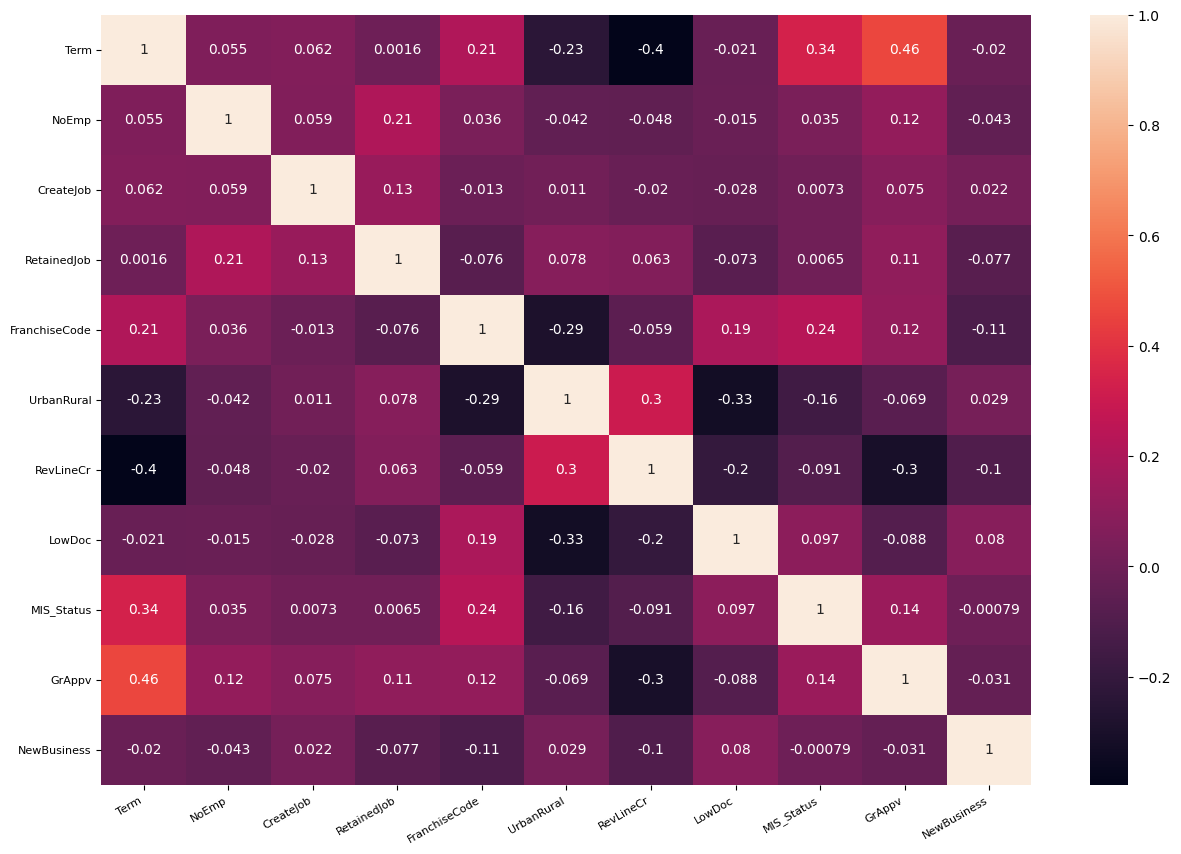

In [342]:
# Select only numeric columns
numeric_columns = credit.select_dtypes(include=['int', 'float']).columns
corr_matrix = credit[numeric_columns].corr()

# Plot the heatmap
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, ax=cor_ax)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Most of the correlations seem pretty obvious: Long term loans get bigger amounts approven, loans with longer terms get paid off more, etc.

I will try some graphs to better visualize the information:

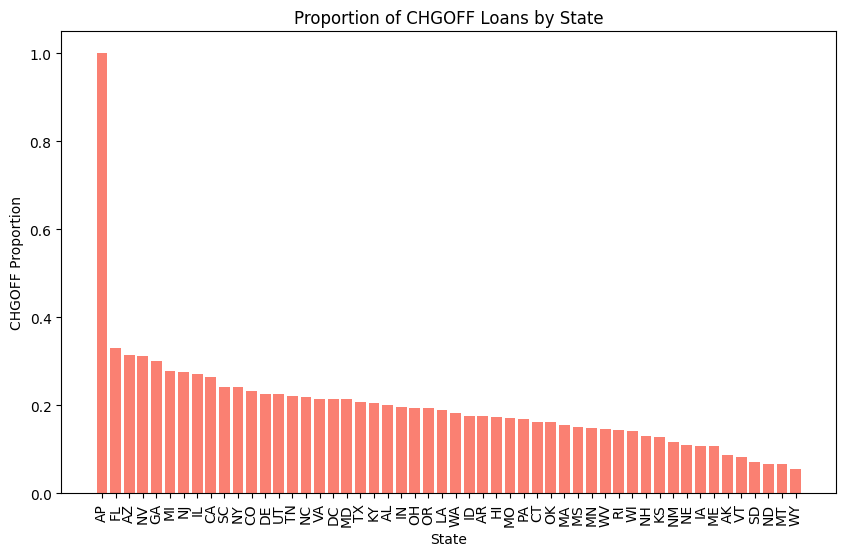

In [343]:
state_counts = credit.groupby(['State', 'MIS_Status']).size().reset_index(name='count')
total_by_state = credit.groupby('State').size().reset_index(name='total')
merged = state_counts.merge(total_by_state, on='State')
merged['proportion'] = merged['count'] / merged['total']

# Filter only CHGOFF (MIS_Status=0)
chgoff_data = merged[merged['MIS_Status'] == 0].copy()

# Sort states by proportion of CHGOFF
chgoff_data = chgoff_data.sort_values(by='proportion', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(chgoff_data['State'], chgoff_data['proportion'], color='salmon')
plt.title("Proportion of CHGOFF Loans by State")
plt.xlabel("State")
plt.ylabel("CHGOFF Proportion")
plt.xticks(rotation=90)
plt.show()

In [344]:
state_counts = credit.groupby(['State', 'MIS_Status']).size().reset_index(name='count')
total_by_state = credit.groupby('State').size().reset_index(name='total')
merged = state_counts.merge(total_by_state, on='State')
merged['proportion'] = merged['count'] / merged['total']

pif_states = merged[merged['MIS_Status'] == 1].sort_values(by='proportion', ascending=False).head(10)
chgoff_states = merged[merged['MIS_Status'] == 0].sort_values(by='proportion', ascending=False).head(10)

print("Top 10 States by PIF proportion:")
print(pif_states[['State','proportion','count','total']])

print("\nTop 10 States by CHGOFF proportion:")
print(chgoff_states[['State','proportion','count','total']])


Top 10 States by PIF proportion:
    State  proportion  count  total
102    WY    0.943838   1210   1282
54     MT    0.933927   3774   4041
58     ND    0.933585   2474   2650
84     SD    0.929459   1871   2013
94     VT    0.917060   2333   2544
1      AK    0.913160   1020   1117
44     ME    0.891703   2676   3001
26     IA    0.891389   4834   5423
60     NE    0.890300   2524   2835
66     NM    0.882618   2549   2888

Top 10 States by CHGOFF proportion:
   State  proportion  count  total
4     AP    1.000000      1      1
19    FL    0.330386   7735  23412
7     AZ    0.315231   2554   8102
67    NV    0.311507   1275   4093
21    GA    0.300037   3217  10722
45    MI    0.277764   3344  12039
63    NJ    0.274947   3265  11875
29    IL    0.271914   4588  16873
9     CA    0.265378  16455  62006
81    SC    0.242156    656   2709


In [345]:
num_states = credit['State'].nunique()
num_industries = credit['Industry'].nunique()
print(f"Number of unique States: {num_states}")
print(f"Number of unique Industries: {num_industries}")


Number of unique States: 52
Number of unique Industries: 20


In [346]:
industry_stats = credit.groupby(['Industry', 'MIS_Status']).agg({
    'GrAppv': ['mean', 'median'],
    'Term': ['mean', 'median']
}).reset_index()

print(industry_stats)

                    Industry MIS_Status         GrAppv                  Term  \
                                                  mean    median        mean   
0            Accom/Food_serv          0  130112.582893   50000.0   61.254650   
1            Accom/Food_serv          1  239865.708365  100000.0  123.261159   
2   Admin_sup/Waste_Mgmt_Rem          0   53230.970778   30000.0   45.414665   
3   Admin_sup/Waste_Mgmt_Rem          1   94607.591590   37000.0   84.635066   
4           Ag/For/Fish/Hunt          0  327736.326895  205000.0   82.930163   
5           Ag/For/Fish/Hunt          1  275262.746962  180000.0  122.607863   
6         Arts/Entertain/Rec          0  111405.636640   35000.0   57.950911   
7         Arts/Entertain/Rec          1  225284.409017   90000.0  124.671736   
8               Construction          0   70118.392154   35000.0   43.494204   
9               Construction          1  127468.983986   50000.0   89.987690   
10               Educational          0 

<ipython-input-347-79ad6d611a5a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_avg_loan.index, y=industry_avg_loan.values, palette='viridis')


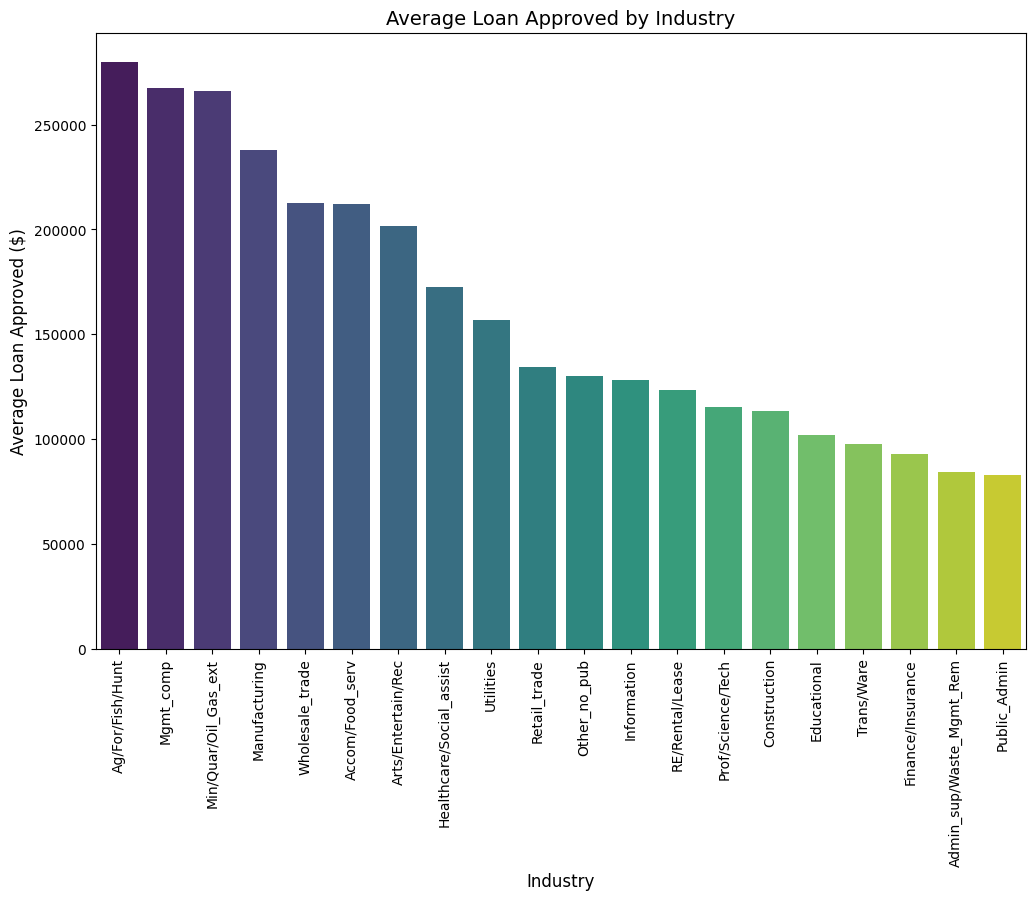

In [347]:
# Group by 'Industry' and calculate the average loan approved (GrAppv)
industry_avg_loan = credit.groupby('Industry')['GrAppv'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=industry_avg_loan.index, y=industry_avg_loan.values, palette='viridis')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better readability
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Average Loan Approved ($)', fontsize=12)
plt.title('Average Loan Approved by Industry', fontsize=14)
plt.show()

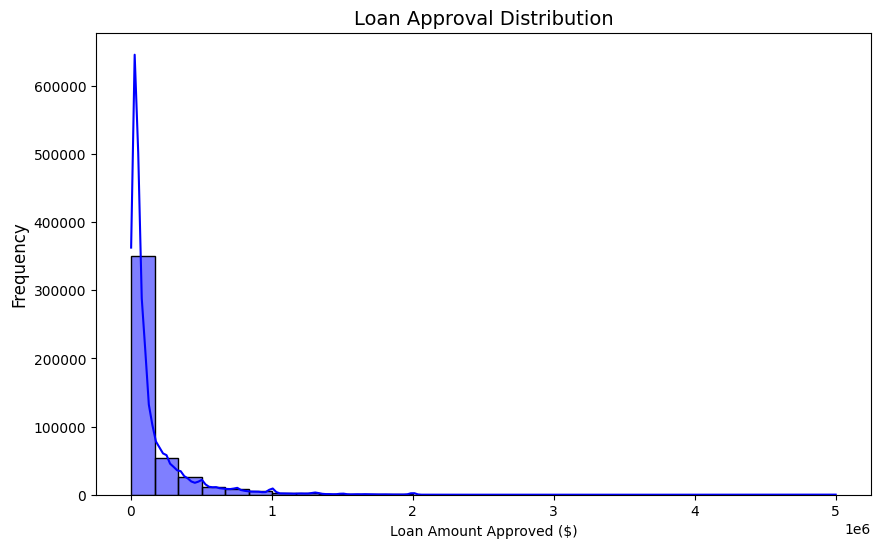

In [348]:
plt.figure(figsize=(10, 6))
sns.histplot(credit['GrAppv'], bins=30, kde=True, color='blue')
plt.title('Loan Approval Distribution', fontsize=14)
plt.xlabel('Loan Amount Approved ($)', fontsize=10)
plt.ylabel('Frequency', fontsize=12)
plt.show()

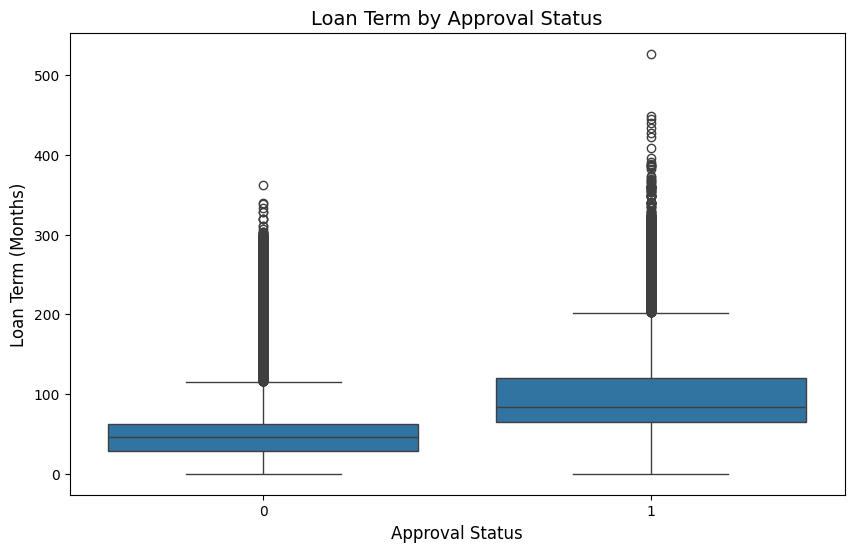

In [349]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='MIS_Status', y='Term', data=credit)
plt.title('Loan Term by Approval Status', fontsize=14)
plt.xlabel('Approval Status', fontsize=12)
plt.ylabel('Loan Term (Months)', fontsize=12)
plt.show()

<ipython-input-350-6160d14fd7cb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_avg_loan.index, y=state_avg_loan.values, palette='viridis')


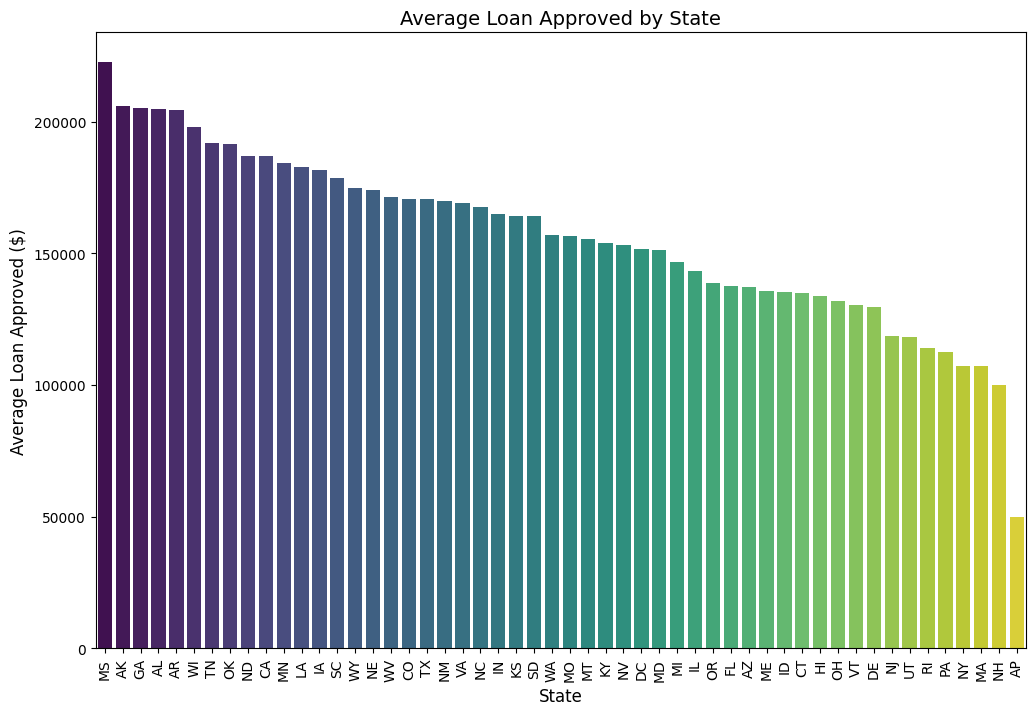

In [350]:
state_avg_loan = credit.groupby('State')['GrAppv'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=state_avg_loan.index, y=state_avg_loan.values, palette='viridis')
plt.xticks(rotation=90, fontsize=10)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Loan Approved ($)', fontsize=12)
plt.title('Average Loan Approved by State', fontsize=14)
plt.show()


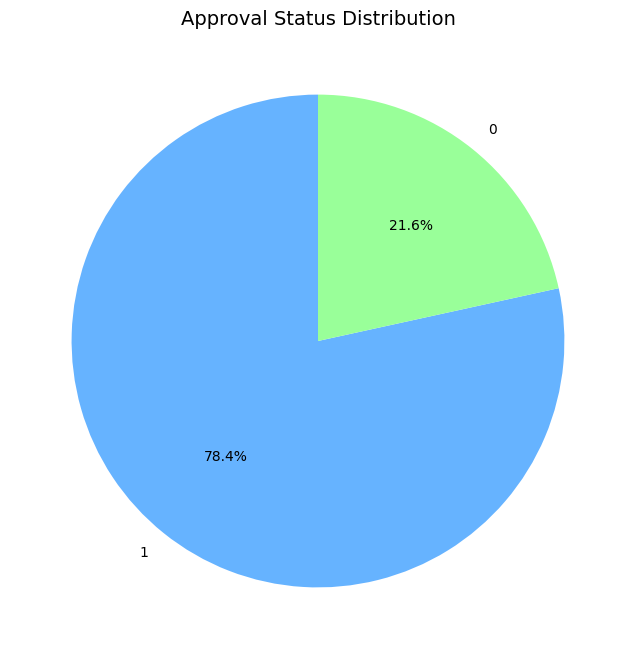

In [351]:
status_counts = credit['MIS_Status'].value_counts()
plt.figure(figsize=(8, 8))
status_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Approval Status Distribution', fontsize=14)
plt.ylabel('')
plt.show()


# Modeling

Now I will start modeling the data. I would like to try at least a couple models. First, a simple one, probably some type of Regression; after that I would like to try XGBoost since it seems to be very effective for this types of problems.

As for the results, I will use many different functions to analyze our results, such as f1_score, accuracy, etc.

------
At this point, I realized that the different bank names give way too little information for the amount of different values that we have. So I decided to drop the column

In [352]:
credit.drop(columns=['Bank'], inplace=True)

------
To begin with, I will use OneHotEncoding since I have many non numerical attributes.

In [353]:
credit = pd.get_dummies(credit)

credit.head()

,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,...,Industry_Mgmt_comp,Industry_Min/Quar/Oil_Gas_ext,Industry_Other_no_pub,Industry_Prof/Science/Tech,Industry_Public_Admin,Industry_RE/Rental/Lease,Industry_Retail_trade,Industry_Trans/Ware,Industry_Utilities,Industry_Wholesale_trade
0,84,4,0,0,1,0,0,1,1,60000.0,...,False,False,False,False,False,False,True,False,False,False
1,60,2,0,0,1,0,0,1,1,40000.0,...,False,False,False,False,False,False,False,False,False,False
2,180,7,0,0,1,0,0,0,1,287000.0,...,False,False,False,False,False,False,False,False,False,False
5,120,19,0,0,1,0,0,0,1,517000.0,...,False,False,False,False,False,False,False,False,False,False
7,84,1,0,0,1,0,0,1,1,45000.0,...,False,False,True,False,False,False,False,False,False,False


We will proceed to split and fit the model.

In [354]:
X = credit.drop(['MIS_Status'], axis=1)
y = credit.MIS_Status

scale = StandardScaler()
X_s = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.25, random_state=0)

In [355]:
log_reg = LogisticRegression(random_state=4)

log_reg.fit(X_train, y_train)
y_logpred = log_reg.predict(X_test)

print(classification_report(y_test, y_logpred))


              precision    recall  f1-score   support

           0       0.74      0.50      0.59     24889
           1       0.87      0.95      0.91     90843

    accuracy                           0.85    115732
   macro avg       0.80      0.72      0.75    115732
weighted avg       0.84      0.85      0.84    115732



We can see that the model is significantly better at predictin class 1 (paid loans) rather than defaulted ones. That makes sense since we have a big class imbalance in this column with a vast majority of paid loans.

We are going to look into this with XGBoost, which should yield better results.

In [356]:
xgb = XGBClassifier(random_state=4)

xgb.fit(X_train, y_train)
y_xgbpred = xgb.predict(X_test)

print(classification_report(y_test, y_xgbpred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     24889
           1       0.96      0.97      0.97     90843

    accuracy                           0.95    115732
   macro avg       0.93      0.92      0.93    115732
weighted avg       0.95      0.95      0.95    115732



As we can see, XGBoost deals much better with our class imbalance problem and predicts both classes with high scores.

Worth noting that class 1 still shows better results, since the dataset is still imbalanced in favor of it, but now we have very high prediction for all metrics.

----------

As a final step, we will look at feature importance for our dataset, to get a better idea of what columns are helping us predict the outcomes. (This is done for the xgb model)

In [357]:
for feat, importance in sorted(zip(X.columns, xgb.feature_importances_), key=lambda x: x[1], reverse=True):
    print(feat, "=", importance)

Term = 0.08908391
UrbanRural = 0.047973074
BankState_VA = 0.043073952
BankState_NC = 0.040289123
BankState_IL = 0.03720925
BankState_CA = 0.037022993
BankState_PA = 0.033063587
State_NC = 0.024511117
FranchiseCode = 0.022738082
BankState_MT = 0.020450497
State_CA = 0.019084394
BankState_FL = 0.017463084
BankState_MN = 0.015816776
BankState_DE = 0.01569935
State_VA = 0.015567714
State_IL = 0.013798177
State_FL = 0.013682058
BankState_VT = 0.013556727
RevLineCr = 0.013544312
State_OR = 0.0133462995
Industry_Healthcare/Social_assist = 0.012521228
BankState_OH = 0.012296976
BankState_OR = 0.012059827
BankState_SC = 0.011989156
BankState_MA = 0.011955777
BankState_MS = 0.010444668
BankState_RI = 0.0103403935
State_ME = 0.010173318
State_NV = 0.009368529
State_AZ = 0.008988768
State_MN = 0.008851048
BankState_HI = 0.008803815
BankState_IN = 0.008302358
GrAppv = 0.008137452
State_GA = 0.008019192
State_PA = 0.007784797
LowDoc = 0.0077428147
State_LA = 0.0075893532
State_ND = 0.0075671943
Bank

As was expected, the length of the Term is the most important factor in predicting the outcome of the payment. The loan being in a rural or urban environment also seems to matter. Other than that, the state of the bank seems to be one of the driving factors, as it seems that banks in certain states (probably giving loans in the same state) are more likely than other of being paid. It seems surprising though, that the origin of the bank is a more important feature than the state where it is given.

# Appendix: Some stats I rendered for the report

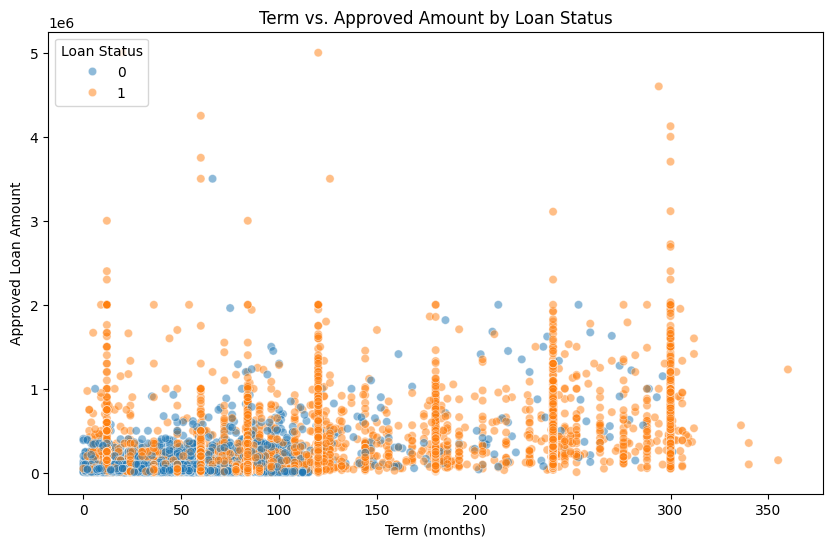

In [358]:
sample_data = credit.sample(20000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Term', y='GrAppv', hue='MIS_Status', alpha=0.5)
plt.title("Term vs. Approved Amount by Loan Status")
plt.xlabel("Term (months)")
plt.ylabel("Approved Loan Amount")
plt.legend(title="Loan Status", loc='upper left')
plt.show()

In [359]:
noemp_desc_pif = credit.loc[credit['MIS_Status']==1, 'NoEmp'].describe()
noemp_desc_chgoff = credit.loc[credit['MIS_Status']==0, 'NoEmp'].describe()

print("NoEmp Stats for PIF (MIS_Status=1):")
print(noemp_desc_pif)
print("\nNoEmp Stats for CHGOFF (MIS_Status=0):")
print(noemp_desc_chgoff)


NoEmp Stats for PIF (MIS_Status=1):
count    363114.000000
mean         10.910199
std          59.928047
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        9999.000000
Name: NoEmp, dtype: float64

NoEmp Stats for CHGOFF (MIS_Status=0):
count    99814.000000
mean         6.103643
std         41.314120
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       8000.000000
Name: NoEmp, dtype: float64


In [360]:
createjob_desc_pif = credit.loc[credit['MIS_Status']==1, 'CreateJob'].describe()
createjob_desc_chgoff = credit.loc[credit['MIS_Status']==0, 'CreateJob'].describe()

retainedjob_desc_pif = credit.loc[credit['MIS_Status']==1, 'RetainedJob'].describe()
retainedjob_desc_chgoff = credit.loc[credit['MIS_Status']==0, 'RetainedJob'].describe()

print("CreateJob Stats for PIF:")
print(createjob_desc_pif)
print("\nCreateJob Stats for CHGOFF:")
print(createjob_desc_chgoff)

print("\nRetainedJob Stats for PIF:")
print(retainedjob_desc_pif)
print("\nRetainedJob Stats for CHGOFF:")
print(retainedjob_desc_chgoff)


CreateJob Stats for PIF:
count    363114.000000
mean          1.971422
std          16.983259
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        5621.000000
Name: CreateJob, dtype: float64

CreateJob Stats for CHGOFF:
count    99814.000000
mean         1.684393
std         13.211497
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max       1618.000000
Name: CreateJob, dtype: float64

RetainedJob Stats for PIF:
count    363114.000000
mean          4.846899
std          15.451949
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max        2200.000000
Name: RetainedJob, dtype: float64

RetainedJob Stats for CHGOFF:
count    99814.000000
mean         4.598153
std         16.420657
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4441.000000
Name: RetainedJob, dtype: float64


In [361]:
lowdoc_summary = credit.groupby(['MIS_Status','LowDoc']).size().reset_index(name='count')
status_totals = credit.groupby('MIS_Status').size().reset_index(name='total')
lowdoc_summary = lowdoc_summary.merge(status_totals, on='MIS_Status')
lowdoc_summary['proportion'] = lowdoc_summary['count'] / lowdoc_summary['total']
print("Proportion of LowDoc Loans by MIS_Status:")
print(lowdoc_summary)

revlinecr_summary = credit.groupby(['MIS_Status','RevLineCr']).size().reset_index(name='count')
revlinecr_summary = revlinecr_summary.merge(status_totals, on='MIS_Status')
revlinecr_summary['proportion'] = revlinecr_summary['count'] / revlinecr_summary['total']
print("\nProportion of RevLineCr Loans by MIS_Status:")
print(revlinecr_summary)


Proportion of LowDoc Loans by MIS_Status:
   MIS_Status  LowDoc   count   total  proportion
0           0       0   98588   99814    0.987717
1           0       1    1226   99814    0.012283
2           1       0  339241  363114    0.934255
3           1       1   23873  363114    0.065745

Proportion of RevLineCr Loans by MIS_Status:
   MIS_Status  RevLineCr   count   total  proportion
0           0          0   49372   99814    0.494640
1           0          1   50442   99814    0.505360
2           1          0  219179  363114    0.603609
3           1          1  143935  363114    0.396391


<ipython-input-362-7e79ab61638e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=credit, x='MIS_Status', y='CreateJob', palette='pastel')


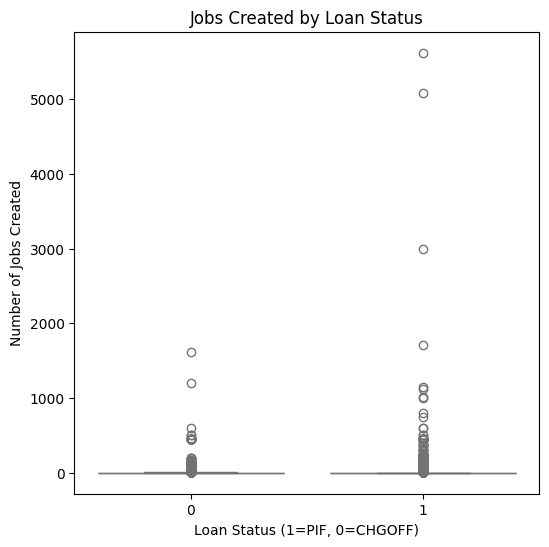

In [362]:
plt.figure(figsize=(6,6))
sns.boxplot(data=credit, x='MIS_Status', y='CreateJob', palette='pastel')
plt.title("Jobs Created by Loan Status")
plt.xlabel("Loan Status (1=PIF, 0=CHGOFF)")
plt.ylabel("Number of Jobs Created")
plt.show()


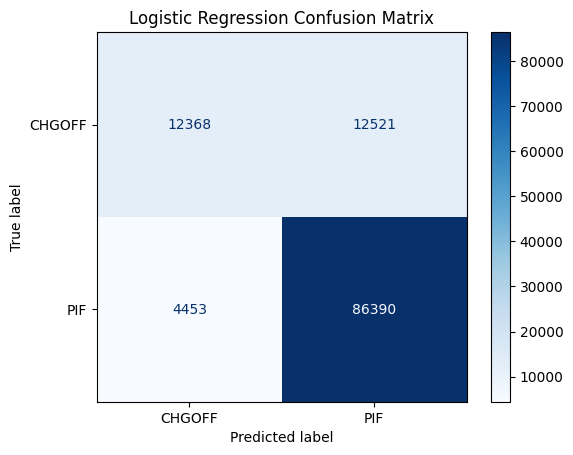

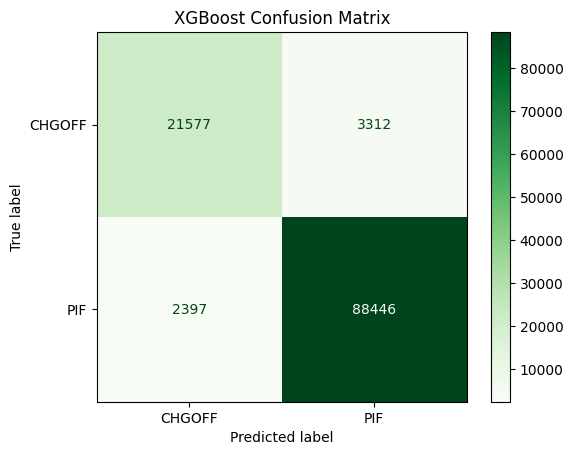

In [363]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression confusion matrix
cm_log = confusion_matrix(y_test, y_logpred)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=["CHGOFF","PIF"])
disp_log.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_test, y_xgbpred)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["CHGOFF","PIF"])
disp_xgb.plot(cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.show()


In [364]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=0)

xgb_model = XGBClassifier(random_state=4)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=4, ...)

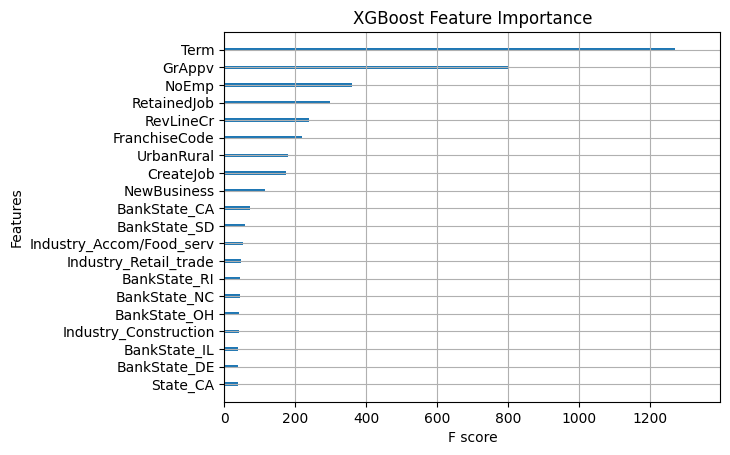

In [365]:
from xgboost import plot_importance


plot_importance(xgb_model, max_num_features=20, importance_type='weight',
                show_values=False, title='XGBoost Feature Importance')
plt.show()

